In [1]:
import json
from typing import List, Dict, Any
import datetime
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
from langchain_community.tools import TavilySearchResults
from langgraph.graph import END, MessageGraph
from pydantic import BaseModel, Field
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm = ChatOpenAI(model="gpt-4.1-mini")

In [4]:
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are expert AI researcher. 
            Current time: {time}

            1. {first_instruction}
            2. Reflect and critique your answer. Be severe to maximize improvement.
            3. After the reflection, **list 1-3 search queries separately** for research improvements. DO NOT include them inside the reflection.
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            """
            Answer the user's question above using the required format.
            """
        )
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat() # pre populate the placeholder time before invoking the chain
)

In [5]:
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous") # what is excessive, what is not needed

class AnswerQuestion(BaseModel):
    """Answer the question."""

    answer: str = Field(
        description="~250 word detailed answer to the question.")
    search_queries: List[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )
    reflection: Reflection = Field(
        description="Your reflection on the initial answer.")
    
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question."""

    references: List[str] = Field(
        description="Citations motivating your updated answer."
    )

In [6]:
first_responder_prompt_template = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 words answer"
)

In [7]:
pydantic_parser = PydanticToolsParser(tools=[AnswerQuestion])

In [8]:
first_responder_chain = first_responder_prompt_template | llm.bind_tools(tools=[AnswerQuestion], tool_choice='AnswerQuestion')

In [9]:
# first_responder_chain.invoke({"messages": [HumanMessage(content="Write a blog post on how small businesses can leverage AI to grow")]})

In [10]:
revise_instructions = """
Revise your previous answer using the new information.
- You should use the previous critique to add important information to your answer.
    - You MUST include numerical citations in your revised answer to ensure it can be verified.
    - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
        - [1] https://example.com
        - [2] https://example.com
- You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.

"""

In [11]:
revisor_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice='ReviseAnswer')

In [12]:
tavily_tool = TavilySearchResults(max_results=5)

In [13]:
def execute_tools(state: list) -> list:
    """Execute tools and return ToolMessages with correct tool_call_ids."""
    last_message = state[-1]  # The assistant's message with tool calls
    if not isinstance(last_message, AIMessage) or not hasattr(last_message, "tool_calls"):
        return []  # No tool calls to process

    tool_messages = []
    for tool_call in last_message.tool_calls:
        tool_call_id = tool_call["id"]  # Extract the tool_call_id
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]

        # Execute the tool (e.g., a search tool like Tavily)
        if tool_name == "AnswerQuestion":  # Adjust based on your tool name
            search_queries = tool_args.get("search_queries", [])
            results = {}
            for query in search_queries:
                # Assuming tavily_tool is your search tool
                result = tavily_tool.invoke(query)
                results[query] = result

            # Create a ToolMessage with the matching tool_call_id
            tool_messages.append(
                ToolMessage(
                    content=json.dumps(results),
                    tool_call_id=tool_call_id
                )
            )
    return tool_messages

In [14]:
MAX_ITERATIONS = 2

In [15]:
def event_loop(state: List[BaseMessage]) -> str:
    count_tool_visits = sum(isinstance(item, ToolMessage) for item in state)
    num_iterations = count_tool_visits
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

In [16]:
graph = MessageGraph()
graph.set_entry_point("initial_response")  # Fixed typo here
graph.add_node("initial_response", first_responder_chain)  # Fixed typo here
graph.add_node("execute_tools", execute_tools)
graph.add_node("revisor", revisor_chain)
graph.add_edge("initial_response", "execute_tools")  # Fixed typo here
graph.add_edge("execute_tools", "revisor")
graph.add_conditional_edges(
    "revisor",
    event_loop,
    {
        "execute_tools": "revisor",
        "end": END
    }
)
app = graph.compile()

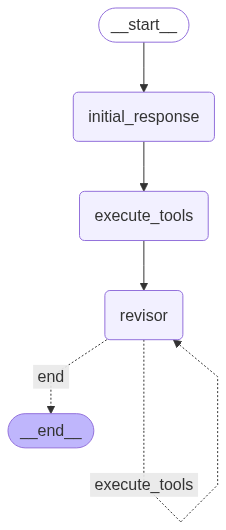

In [17]:
app

In [18]:
app.invoke([HumanMessage(content="Write about how small businesses can leverage AI to grow")])

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_9Ke8vaYObWuIowfbDfyenAQw", 'type': 'invalid_request_error', 'param': 'messages.[5].role', 'code': None}}